<a href="https://colab.research.google.com/github/MoonJaeHoon/dacon_parking_demand/blob/master/EDA2_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
# ## Plot 한글
# # Step 1. Matplotlib 업그레이드
# !pip install matplotlib -U

# # Step 2. 한글 설치 및 사용 설정
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# # Step 3. 런타임 재시작

In [59]:
import os
import pickle
from tqdm import tqdm, tqdm_notebook
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import random
import numpy as np
from pprint import  pprint
import warnings
warnings.filterwarnings('ignore')
# 한글폰트 설정, 그래프 마이너스 표시 설정
import matplotlib
from matplotlib import font_manager, rc
from matplotlib import pyplot as plt
import platform
import seaborn as sns

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')

plt.rcParams['font.family']=['NanumGothic', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['axes.unicode_minus'] = False

seed=47
def set_seed(seed: int = 42, contain_cuda: bool = False):
    random.seed(seed)
    np.random.seed(seed)

    # if contain_cuda:
    #     torch.backends.cudnn.deterministic = True
    #     torch.backends.cudnn.benchmark = False

    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)
    print(f"seed set as {seed}")
set_seed(seed)

seed set as 47


In [60]:
cd /content/drive/MyDrive/dacon_parking_data

/content/drive/MyDrive/dacon_parking_data


In [61]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
age_gender_info = pd.read_csv('./data/age_gender_info.csv')
submission = pd.read_csv('./data/sample_submission.csv')
print(f"train.shape : {train.shape}")
print(f"test.shape : {test.shape}")

# print(f"len(train.columns) : {len(train.columns)}")
# print(f"len(test.columns) : {len(test.columns)}")

train.shape : (2952, 15)
test.shape : (1022, 14)


In [62]:
print("Train set NULL")
print({k:v for k,v in train.isnull().sum().to_dict().items() if v!=0})
print("Test set NULL")
print({k:v for k,v in test.isnull().sum().to_dict().items() if v!=0})

Train set NULL
{'임대보증금': 569, '임대료': 569, '도보 10분거리 내 지하철역 수(환승노선 수 반영)': 211, '도보 10분거리 내 버스정류장 수': 4}
Test set NULL
{'자격유형': 2, '임대보증금': 180, '임대료': 180, '도보 10분거리 내 지하철역 수(환승노선 수 반영)': 42}


In [63]:
# 임대보증금과 임대료는 '-'을 null로 바꾼 후 float로 타입 변경
train.loc[train.임대보증금=='-', '임대보증금'] = np.nan
test.loc[test.임대보증금=='-', '임대보증금'] = np.nan
train['임대보증금'] = train['임대보증금'].astype(float)
test['임대보증금'] = test['임대보증금'].astype(float)

train.loc[train.임대료=='-', '임대료'] = np.nan
test.loc[test.임대료=='-', '임대료'] = np.nan
train['임대료'] = train['임대료'].astype(float)
test['임대료'] = test['임대료'].astype(float)

In [64]:
# 임대보증금과 임대료가 NULL인 경우는 0으로 대체하는 것이 좋아보임
train[['임대보증금', '임대료']] = train[['임대보증금', '임대료']].fillna(0)
test[['임대보증금', '임대료']] = test[['임대보증금', '임대료']].fillna(0)

In [65]:
print("Train set NULL")
print({k:v for k,v in train.isnull().sum().to_dict().items() if v!=0})
print("Test set NULL")
print({k:v for k,v in test.isnull().sum().to_dict().items() if v!=0})

Train set NULL
{'도보 10분거리 내 지하철역 수(환승노선 수 반영)': 211, '도보 10분거리 내 버스정류장 수': 4}
Test set NULL
{'자격유형': 2, '도보 10분거리 내 지하철역 수(환승노선 수 반영)': 42}


In [66]:
cols = ['도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수']
train[cols] = train[cols].fillna(0)
test[cols] = test[cols].fillna(0)

In [67]:
test[test.단지코드=='C2411'] # A로 채우면 될듯

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
193,C2411,962,아파트,경상남도,국민임대,39.43,56,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
194,C2411,962,아파트,경상남도,국민임대,39.72,336,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
195,C2411,962,아파트,경상남도,국민임대,39.82,179,25.0,A,11992000.0,100720.0,0.0,2.0,840.0
196,C2411,962,아파트,경상남도,국민임대,46.90,240,25.0,NaN,71950000.0,37470.0,0.0,2.0,840.0
197,C2411,962,아파트,경상남도,국민임대,51.93,150,25.0,A,21586000.0,171480.0,0.0,2.0,840.0


In [68]:
test.loc[test.단지코드.isin(['C2411']) & test.자격유형.isnull(), '자격유형'] = 'A'

In [69]:
test[test.단지코드=='C2253'].head() # 임대보증금과 임대료가 존재하는 경우 자격유형이 C => C로 채우면 될듯

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
258,C2253,1161,아파트,강원도,영구임대,26.37,745,0.0,NaN,2249000.0,44770.0,0.0,2.0,173.0
259,C2253,1161,아파트,강원도,영구임대,31.32,239,0.0,C,3731000.0,83020.0,0.0,2.0,173.0
260,C2253,1161,아파트,강원도,영구임대,31.32,149,0.0,C,3731000.0,83020.0,0.0,2.0,173.0
261,C2253,1161,상가,강원도,임대상가,13.77,1,0.0,D,0.0,0.0,0.0,2.0,173.0
262,C2253,1161,상가,강원도,임대상가,22.89,1,0.0,D,0.0,0.0,0.0,2.0,173.0


In [70]:
test.loc[test.단지코드.isin(['C2253']) & test.자격유형.isnull(), '자격유형'] = 'C'

In [71]:
print("Train set NULL")
print({k:v for k,v in train.isnull().sum().to_dict().items() if v!=0})
print("Test set NULL")
print({k:v for k,v in test.isnull().sum().to_dict().items() if v!=0})

Train set NULL
{}
Test set NULL
{}


+ 중복되는 데이터는 제거하고 분석을 진행하는 것이 좋아보임 (일단 중복제거 안하고 진행해보기)

In [72]:
# train = train.drop_duplicates()
# test = test.drop_duplicates()

In [73]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000.0,103680.0,0.0,3.0,1425.0,1015.0
1,C2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000.0,103680.0,0.0,3.0,1425.0,1015.0
2,C2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0
3,C2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0
4,C2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0


## 공급유형의 category 묶어주기 (항목들 중 train에는 있지만 test에 존재하지 않는 항목들 존재)

In [74]:
train['공급유형'].value_counts()

국민임대         1758
임대상가          562
행복주택          213
공공임대(10년)     205
영구임대          152
공공임대(50년)      31
공공임대(분납)       12
장기전세            9
공공분양            7
공공임대(5년)        3
Name: 공급유형, dtype: int64

In [75]:
# 공급유형의 항목들 중 train에는 있지만 test에는 존재하지 않는 항목들이 존재.
pd.concat([train.공급유형.value_counts(), test.공급유형.value_counts()], axis=1)
# 장기전세, => 
# 공공분양, => 
# 공공임대(5년) => 공공임대(10년)과 묶자.

,공급유형,공급유형
국민임대,1758,622.0
임대상가,562,177.0
행복주택,213,124.0
공공임대(10년),205,35.0
영구임대,152,45.0
공공임대(50년),31,13.0
공공임대(분납),12,6.0
장기전세,9,NaN
공공분양,7,NaN
공공임대(5년),3,NaN


In [76]:
# 공공임대(5년)은 공공임대(10년)과 묶어버리자.
# 공공임대(5년/10년)
category = '공공임대(5년)'
print('='*25 + f'\n{category}')
print(train.loc[train.공급유형==category,['임대료','임대보증금']].mean(axis=0))
category = '공공임대(10년)'
print('='*25 + f'\n{category}')
print(train.loc[train.공급유형==category,['임대료','임대보증금']].mean(axis=0))

공공임대(5년)
임대료        400000.0
임대보증금    27000000.0
dtype: float64
공공임대(10년)
임대료      5.212868e+05
임대보증금    5.098770e+07
dtype: float64


In [106]:
train.loc[train.공급유형.isin(['공공임대(5년)','공공임대(10년)']),'공급유형'] = '공급유형(5년/10년)'
test.loc[test.공급유형.isin(['공공임대(5년)','공공임대(10년)']),'공급유형'] = '공급유형(5년/10년)'

In [107]:
# 공공분양은 과 묶어버리자.
category = '공공분양'
print('='*25 + f'\n{category}')
print(train.loc[train.공급유형==category,['임대료','임대보증금']].mean(axis=0))

공공분양
임대료      0.0
임대보증금    0.0
dtype: float64


In [108]:
# 장기전세는 과 묶어보자.
category = '장기전세'
print('='*25 + f'\n{category}')
print(train.loc[train.공급유형==category,['임대료','임대보증금']].median(axis=0))

장기전세
임대료              0.0
임대보증금    194562000.0
dtype: float64


In [109]:
result_median = pd.DataFrame(columns=['임대료','임대보증금'])
for category in train.공급유형.unique():
    temp_per_category = train.loc[train.공급유형==category,['임대료','임대보증금']].median(axis=0).to_frame().rename(columns={0:f"{category}_median"}).T
    temp_per_category
    result_median = pd.concat([result_median,temp_per_category],axis=0)

result_mean = pd.DataFrame(columns=['임대료','임대보증금'])
for category in train.공급유형.unique():
    temp_per_category = train.loc[train.공급유형==category,['임대료','임대보증금']].mean(axis=0).to_frame().rename(columns={0:f"{category}_mean"}).T
    temp_per_category
    result_mean = pd.concat([result_mean,temp_per_category],axis=0)

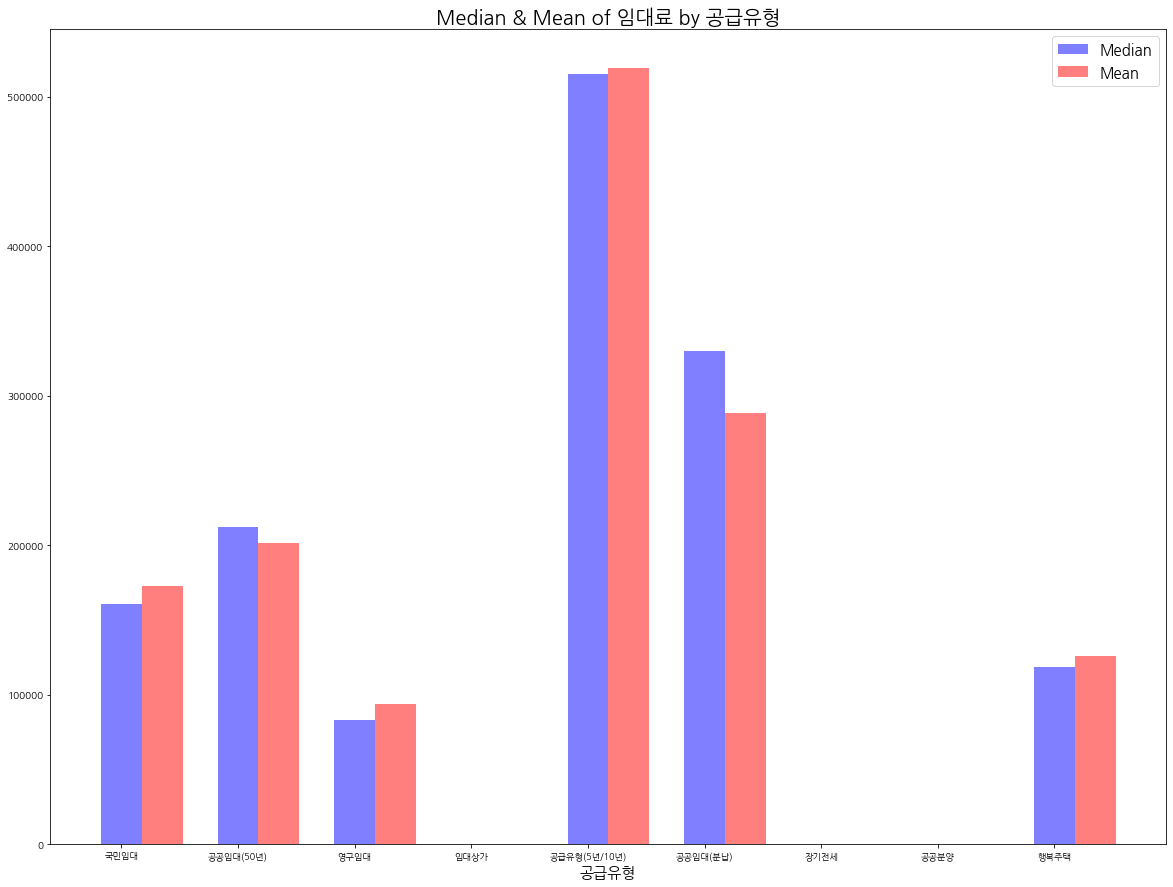

In [110]:
# 공공분양, 장기전세

bar_width = 0.35
index = np.arange(len(result_median))

plt.figure(figsize=(20,15))

p1 = plt.bar(index,result_median['임대료'],
             width=bar_width,
             color='b',
             alpha=0.5,
             )
p2 = plt.bar(index + bar_width, result_mean['임대료'], 
             width=bar_width, 
             color='r', 
             alpha=0.5,
            )

plt.title('Median & Mean of 임대료 by 공급유형', fontsize=20)
plt.xlabel('공급유형', fontsize=15)
plt.xticks(index, [id.replace('_median','') for id in result_median.index], fontsize=9)
plt.legend((p1[0], p2[0]), ('Median', 'Mean'), fontsize=15)
plt.show()

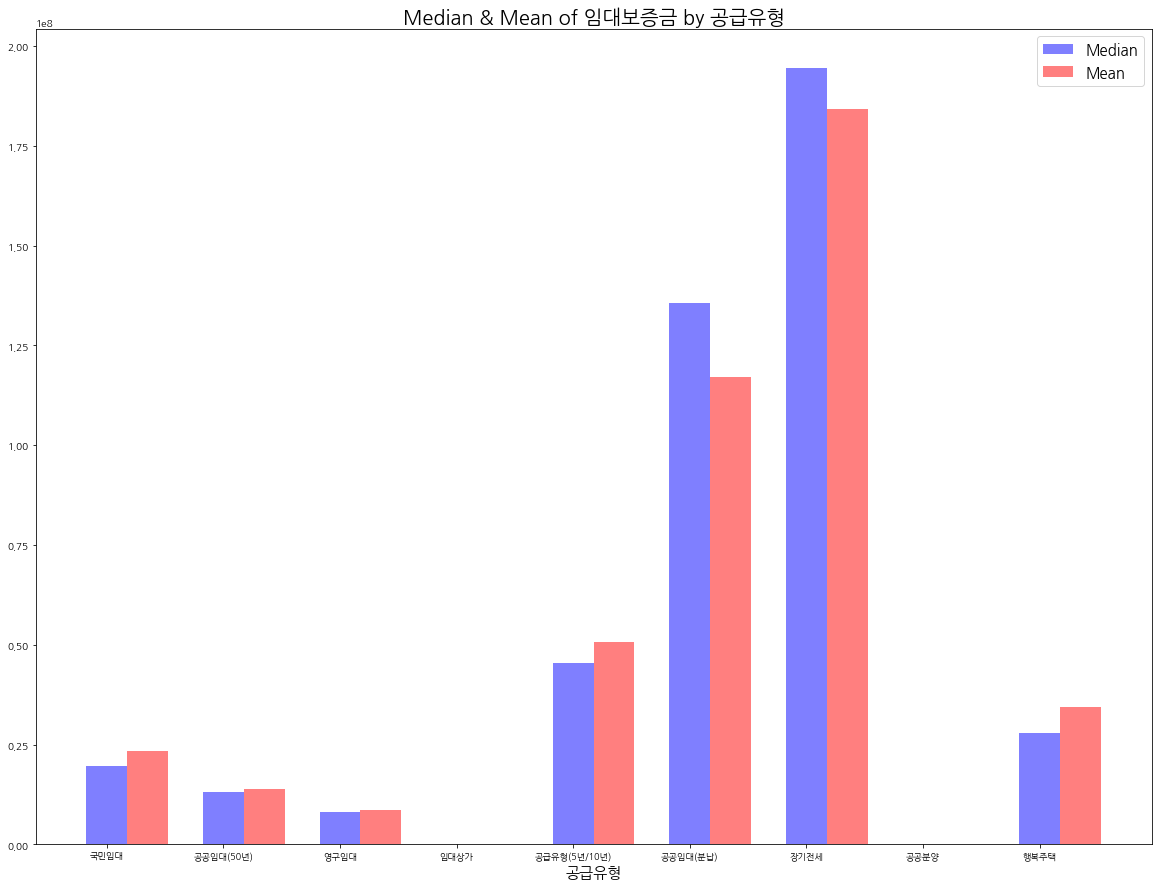

In [111]:
bar_width = 0.35
index = np.arange(len(result_median))

plt.figure(figsize=(20,15))

p1 = plt.bar(index,result_median['임대보증금'],
             width=bar_width,
             color='b',
             alpha=0.5,
             )
p2 = plt.bar(index + bar_width, result_mean['임대보증금'], 
             width=bar_width, 
             color='r', 
             alpha=0.5,
            )

plt.title('Median & Mean of 임대보증금 by 공급유형', fontsize=20)
plt.xlabel('공급유형', fontsize=15)
plt.xticks(index, [id.replace('_median','') for id in result_median.index], fontsize=9)
plt.legend((p1[0], p2[0]), ('Median', 'Mean'), fontsize=15)
plt.show()

In [127]:

print(train.loc[train.공급유형.isin(['공공임대(5년/10년)','공공임대(50년)']),'전용면적'].min())
print(train.loc[train.공급유형.isin(['공공임대(5년/10년)','공공임대(50년)']),'전용면적'].max())

35.28
49.95


In [124]:
# https://www.lh.or.kr/contents/cont.do
print(train.loc[train.공급유형=='국민임대','전용면적'].min())
print(train.loc[train.공급유형=='국민임대','전용면적'].max())

21.97
59.99


In [125]:
# https://housing.seoul.go.kr/site/main/content/sh01_030600
print(train.loc[train.공급유형=='장기전세','전용면적'].min())
print(train.loc[train.공급유형=='장기전세','전용면적'].max())

23.32
59.94


In [126]:
# https://www.lh.or.kr/contents/cont.do
print(train.loc[train.공급유형=='공공분양','전용면적'].min())
print(train.loc[train.공급유형=='공공분양','전용면적'].max())

74.94
84.97


In [116]:
train.loc[train.공급유형=='공공분양','자격유형'].value_counts()

D    7
Name: 자격유형, dtype: int64

In [118]:
print(train.loc[train.자격유형=='D','공급유형'].value_counts())
print(test.loc[test.자격유형=='D','공급유형'].value_counts())

임대상가    562
공공분양      7
Name: 공급유형, dtype: int64
임대상가    177
영구임대      3
Name: 공급유형, dtype: int64


In [119]:
train.loc[train.공급유형=='장기전세','자격유형'].value_counts()

A    9
Name: 자격유형, dtype: int64

In [121]:
print(train.loc[train.자격유형=='A','공급유형'].value_counts())
print(test.loc[test.자격유형=='A','공급유형'].value_counts())

국민임대            1539
공급유형(5년/10년)     208
공공임대(50년)         31
공공임대(분납)          12
장기전세               9
영구임대               2
Name: 공급유형, dtype: int64
국민임대            519
공급유형(5년/10년)     35
공공임대(50년)        13
공공임대(분납)          6
Name: 공급유형, dtype: int64


### 자격유형 category 묶기

> B, F, O는 다른 어떤 항목에 포함시켜 무조건 묶어줘야함


1. O는 'J', 'L', 'K', 'N', 'M', 'O'로 묶어서 '행복주택_공급대상'으로
2. B는 'B','H','G'로 묶어서 '국민임대_공급대상'으로
3. F는 'C','I','F'로 묶어서 '영구임대_공급대상'으로

In [82]:
# 자격유형의 항목들 중 train에는 있지만 test에는 존재하지 않는 항목들이 존재.
pd.concat([train.자격유형.value_counts(), test.자격유형.value_counts()], axis=1)
# B, F, O

,자격유형,자격유형
A,1801,573.0
D,569,180.0
H,155,92.0
J,114,84.0
C,95,35.0
I,49,7.0
E,37,10.0
K,33,16.0
L,33,12.0
N,30,10.0


1. 'J', 'L', 'K', 'N', 'M', 'O' 묶어버리기 => 행복주택_공급대상

In [86]:
# 'J', 'L', 'K', 'N', 'M', 'O' 는 공급유형이 행복주택인 경우에서만 나타남 이것만 따로 묶는게 좋을듯
train.loc[train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '공급유형'].value_counts()

행복주택    213
Name: 공급유형, dtype: int64

In [87]:
train.loc[train.공급유형=='행복주택', '자격유형'].value_counts()

J    114
L     33
K     33
N     30
M      2
O      1
Name: 자격유형, dtype: int64

In [88]:
train.loc[train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'
test.loc[test.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'

2. 'B','H','G' 묶어버리기 => 국민임대_공급대상

In [89]:
train.loc[train.자격유형=='B','공급유형'].value_counts()

국민임대    21
Name: 공급유형, dtype: int64

In [90]:
train.loc[train.공급유형=='국민임대', '자격유형'].value_counts()

A    1539
H     155
E      34
B      21
G       9
Name: 자격유형, dtype: int64

In [91]:
train.loc[train.자격유형.isin(['A', 'H', 'E', 'B', 'G']), '공급유형'].value_counts()


국민임대         1758
공공임대(10년)     205
공공임대(50년)      31
공공임대(분납)       12
장기전세            9
영구임대            5
공공임대(5년)        3
Name: 공급유형, dtype: int64

In [92]:
train.loc[train.자격유형=='A','공급유형'].value_counts()

국민임대         1539
공공임대(10년)     205
공공임대(50년)      31
공공임대(분납)       12
장기전세            9
공공임대(5년)        3
영구임대            2
Name: 공급유형, dtype: int64

In [93]:
print(train.loc[train.자격유형=='H','공급유형'].value_counts())
print(test.loc[test.자격유형=='H','공급유형'].value_counts())

국민임대    155
Name: 공급유형, dtype: int64
국민임대    92
Name: 공급유형, dtype: int64


In [94]:
print(train.loc[train.자격유형=='E','공급유형'].value_counts())
print(test.loc[test.자격유형=='E','공급유형'].value_counts())

국민임대    34
영구임대     3
Name: 공급유형, dtype: int64
국민임대    10
Name: 공급유형, dtype: int64


In [95]:
print(train.loc[train.자격유형=='G','공급유형'].value_counts())
print(test.loc[test.자격유형=='G','공급유형'].value_counts())

국민임대    9
Name: 공급유형, dtype: int64
국민임대    1
Name: 공급유형, dtype: int64


In [96]:
train.loc[train.자격유형.isin(['B','H','G']), '자격유형'] = '국민임대_공급대상'
test.loc[test.자격유형.isin(['B','H','G']), '자격유형'] = '국민임대_공급대상'

3. 'F','C','I' 묶어버리기 => 국민임대_공급대상

In [97]:
print(train.loc[train.자격유형=='F','공급유형'].value_counts())

영구임대    3
Name: 공급유형, dtype: int64


In [98]:
print(train.loc[train.공급유형=='영구임대', '자격유형'].value_counts())
print(test.loc[test.공급유형=='영구임대', '자격유형'].value_counts())

C    95
I    49
F     3
E     3
A     2
Name: 자격유형, dtype: int64
C    35
I     7
D     3
Name: 자격유형, dtype: int64


In [99]:
# C는 영구임대_공급대상에 포함.
print(train.loc[train.자격유형=='C','공급유형'].value_counts())
print(test.loc[test.자격유형=='C','공급유형'].value_counts())

영구임대    95
Name: 공급유형, dtype: int64
영구임대    35
Name: 공급유형, dtype: int64


In [100]:
# I도 영구임대_공급대상에 포함.
print(train.loc[train.자격유형=='I','공급유형'].value_counts())
print(test.loc[test.자격유형=='I','공급유형'].value_counts())

영구임대    49
Name: 공급유형, dtype: int64
영구임대    7
Name: 공급유형, dtype: int64


In [101]:
# E는 only 영구임대_공급대상 X
print(train.loc[train.자격유형=='E','공급유형'].value_counts())
print(test.loc[test.자격유형=='E','공급유형'].value_counts())

국민임대    34
영구임대     3
Name: 공급유형, dtype: int64
국민임대    10
Name: 공급유형, dtype: int64


In [102]:
# A는 only 영구임대_공급대상 X
print(train.loc[train.자격유형=='A','공급유형'].value_counts())
print(test.loc[test.자격유형=='A','공급유형'].value_counts())

국민임대         1539
공공임대(10년)     205
공공임대(50년)      31
공공임대(분납)       12
장기전세            9
공공임대(5년)        3
영구임대            2
Name: 공급유형, dtype: int64
국민임대         519
공공임대(10년)     35
공공임대(50년)     13
공공임대(분납)       6
Name: 공급유형, dtype: int64


In [103]:
# D는 only 영구임대_공급대상 X
print(train.loc[train.자격유형=='D','공급유형'].value_counts())
print(test.loc[test.자격유형=='D','공급유형'].value_counts())

임대상가    562
공공분양      7
Name: 공급유형, dtype: int64
임대상가    177
영구임대      3
Name: 공급유형, dtype: int64


In [104]:
train.loc[train.자격유형.isin(['C','I','F']), '자격유형'] = '영구임대_공급대상'
test.loc[test.자격유형.isin(['C','I','F']), '자격유형'] = '영구임대_공급대상'

In [105]:
print(train.자격유형.value_counts())
print(test.자격유형.value_counts())

A            1801
D             569
행복주택_공급대상     213
국민임대_공급대상     185
영구임대_공급대상     147
E              37
Name: 자격유형, dtype: int64
A            573
D            180
행복주택_공급대상    124
국민임대_공급대상     93
영구임대_공급대상     42
E             10
Name: 자격유형, dtype: int64


## 단지코드별로 agg

In [28]:
# 423개가 넘는 범주를 가지고 있다면, agg가 필요한 변수임
print(len(set(train['단지코드']))) 
print('='*50)
tr_nunique_groupby_danjicode = train.groupby(['단지코드']).nunique(dropna=False).sum(axis=0)
tr_nunique_groupby_danjicode

423


총세대수                             423
임대건물구분                           456
지역                               423
공급유형                             488
전용면적                            1898
전용면적별세대수                        2230
공가수                              423
자격유형                             510
임대보증금                           1277
임대료                             1289
도보 10분거리 내 지하철역 수(환승노선 수 반영)     423
도보 10분거리 내 버스정류장 수               423
단지내주차면수                          423
등록차량수                            423
dtype: int64

In [29]:
# 150개가 넘는 범주를 가지고 있다면, agg가 필요한 변수임
print(len(set(test['단지코드'])))
print('='*50)
te_nunique_groupby_danjicode = test.groupby(['단지코드']).nunique(dropna=False).sum(axis=0)
te_nunique_groupby_danjicode

150


총세대수                            150
임대건물구분                          157
지역                              150
공급유형                            167
전용면적                            693
전용면적별세대수                        797
공가수                             150
자격유형                            178
임대보증금                           459
임대료                             461
도보 10분거리 내 지하철역 수(환승노선 수 반영)    150
도보 10분거리 내 버스정류장 수              150
단지내주차면수                         150
dtype: int64

In [30]:
# agg 필요없는 변수들
tr_not_need_agg = ['단지코드']+tr_nunique_groupby_danjicode[tr_nunique_groupby_danjicode<=len(set(train['단지코드']))].index.tolist()
print(tr_not_need_agg)
print(len(tr_not_need_agg))
te_not_need_agg = ['단지코드']+te_nunique_groupby_danjicode[te_nunique_groupby_danjicode<=len(set(test['단지코드']))].index.tolist()
print(te_not_need_agg)
print(len(te_not_need_agg))

['단지코드', '총세대수', '지역', '공가수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '단지내주차면수', '등록차량수']
8
['단지코드', '총세대수', '지역', '공가수', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수', '단지내주차면수']
7


In [31]:
# agg 필요없는 변수들
df = train.loc[:,tr_not_need_agg].drop_duplicates()
print(df.shape)
df_test = test.loc[:,te_not_need_agg].drop_duplicates()
print(df_test.shape)
df.head()

(423, 8)
(150, 7)


,단지코드,총세대수,지역,공가수,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,경상북도,38.0,0.0,3.0,1425.0,1015.0
8,C2515,545,경상남도,17.0,0.0,3.0,624.0,205.0
15,C1407,1216,대전광역시,13.0,1.0,1.0,1285.0,1064.0
26,C1945,755,경기도,6.0,1.0,3.0,734.0,730.0
32,C1470,696,전라북도,14.0,0.0,2.0,645.0,553.0


In [32]:
# agg 필요한 변수들
tr_need_agg = tr_nunique_groupby_danjicode[tr_nunique_groupby_danjicode>len(set(train['단지코드']))].index.tolist()
print(tr_need_agg)
print(len(tr_need_agg))
te_need_agg = te_nunique_groupby_danjicode[te_nunique_groupby_danjicode>len(set(test['단지코드']))].index.tolist()
print(te_need_agg)
print(len(te_need_agg))

['임대건물구분', '공급유형', '전용면적', '전용면적별세대수', '자격유형', '임대보증금', '임대료']
7
['임대건물구분', '공급유형', '전용면적', '전용면적별세대수', '자격유형', '임대보증금', '임대료']
7


In [33]:
# continuous_variables : '전용면적','전용면적별세대수','임대보증금','임대료'
continuous_variables = ['전용면적','전용면적별세대수','임대보증금','임대료']
# https://rfriend.tistory.com/275
contfeature = '전용면적'
def reshaping_contfeature_by_pivot(input_df, from_data, contfeature):
    agg_dict_for_map = from_data.groupby(['단지코드'])[contfeature].agg(['mean','median','min','max','std','count','sum']).to_dict()
    result_df = input_df.copy()
    for key in agg_dict_for_map.keys():
        result_df[f'{contfeature}_{key}'] = input_df['단지코드'].map(agg_dict_for_map[key])
    return result_df

print(df.shape)
for contfeature in continuous_variables:
    df = reshaping_contfeature_by_pivot(df, train, contfeature)
df = df.fillna(0).reset_index(drop=True)   # row가 1개뿐인 group의 std는 null값이 도출됨.
print(df.shape)
print('='*50)
print(df_test.shape)
for contfeature in continuous_variables:
    df_test = reshaping_contfeature_by_pivot(df_test, test, contfeature)
df_test = df_test.fillna(0).reset_index(drop=True)   # row가 1개뿐인 group의 std는 null값이 도출됨.
print(df_test.shape)

(423, 8)
(423, 36)
(150, 7)
(150, 35)


In [34]:
# categorical_variables : '임대건물구분', '공급유형', '자격유형'
categorical_variables = ['임대건물구분', '공급유형', '자격유형']
def reshaping_catfeature_by_pivot(data, catfeature, value_col):
    result_df = data.drop_duplicates(['단지코드', catfeature]).assign(counter=1).pivot(index='단지코드', columns=catfeature, values=value_col).fillna(0)
    result_df.columns.name = None
    result_df = result_df.rename(columns={col:f"{catfeature}_{col}_{value_col}" for col in result_df.columns})
    return result_df

print(df.shape)
for catfeature in categorical_variables:
    reshaped_data = reshaping_catfeature_by_pivot(train, catfeature, value_col='counter').reset_index(drop=True)
    df = pd.concat([df,reshaped_data],axis=1)
print(df.shape)
print('='*50)
print(df_test.shape)
for catfeature in categorical_variables:
    reshaped_data = reshaping_catfeature_by_pivot(test, catfeature, value_col='counter').reset_index(drop=True)
    df_test = pd.concat([df_test,reshaped_data],axis=1)
print(df_test.shape)

(423, 36)
(423, 63)
(150, 35)
(150, 56)
